# XAFS scan

From *APS Python Training for Bluesky Data Acquisition*.

**Objective**

Example multi-segment XAFS scan.  A full scan might be divided into:

region | steps | units | count time
--- | --- | --- | ---
pre-edge | constant energy | keV | constant
near-edge | constant energy | eV | constant
low _k_ | constant k | 1/angstrom | constant
higher _k_ | constant k | 1/angstrom | scales with _k_

For the higher _k_ region, the count time is computed as:

    preset_time = requested_time * (1 + factor*k**exponent)

where `exponent=0.5`, `factor=2.0`, and `requested_time` is the time specified by the caller.

note: We are connected to _simulated_ hardware.  The simulated scalers generate random pulses. All detector data is random numbers.

## Start the `instrument` package

Our instrument package is in the `bluesky` subdirectory here so we add that to the search path before importing it.

In [1]:
import pathlib, sys
sys.path.append(str(pathlib.Path.home() / "bluesky"))
from instrument.collection import *

RE.waiting_hook = None  # disable the progress bar, looks awful in notebooks

/home/prjemian/bluesky/instrument/_iconfig.py
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/docs/source/howto/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Thu-18:16:30 - ############################################################ startup
I Thu-18:16:30 - logging started
I Thu-18:16:30 - logging level = 10
I Thu-18:16:30 - /home/prjemian/bluesky/instrument/session_logs.py
I Thu-18:16:30 - /home/prjemian/bluesky/instrument/collection.py
I Thu-18:16:30 - CONDA_PREFIX = /home/prjemian/.conda/envs/bluesky_2023_2


Exception reporting mode: Minimal


I Thu-18:16:30 - xmode exception level: 'Minimal'
I Thu-18:16:30 - /home/prjemian/bluesky/instrument/mpl/notebook.py
I Thu-18:16:30 - #### Bluesky Framework ####
I Thu-18:16:30 - /home/prjemian/bluesky/instrument/framework/check_python.py
I Thu-18:16:30 - /home/prjemian/bluesky/instrument/framework/check_bluesky.py
I Thu-18:16:30 - /home/prjemian/bluesky/instrument/framework/initialize.py
I Thu-18:16:30 - RunEngine metadata saved in directory: /home/prjemian/Bluesky_RunEngine_md
I Thu-18:16:30 - using databroker catalog 'training'
I Thu-18:16:30 - using ophyd control layer: pyepics
I Thu-18:16:30 - /home/prjemian/bluesky/instrument/framework/metadata.py
I Thu-18:16:30 - /home/prjemian/bluesky/instrument/epics_signal_config.py
I Thu-18:16:30 - Using RunEngine metadata for scan_id
I Thu-18:16:30 - #### Devices ####
I Thu-18:16:30 - /home/prjemian/bluesky/instrument/devices/area_detector.py
I Thu-18:16:30 - /home/prjemian/bluesky/instrument/devices/calculation_records.py
I Thu-18:16:33 - 

We'll use these later.  Import now.

In [2]:
from ophyd import EpicsSignalRO

import math
import numpy as np
import pandas as pd

## Energy & _k_

The Kohzu monochromator support expects energy in *keV* and wavelength in
*1/angstrom*.  XAFS is similar, _k_ in *1/angstrom*, but also uses *eV*
sometimes for energy.  We need to be flexible.

Fundamental physical constants are provided by the
[scipy](https://www.scipy.org/) package.  The Python
[pint](https://pint.readthedocs.io/) package is used to provide
unit conversions that will help to convert between energy and _k_
coordinates.
With these two packages, our software provides flexibility for the units
a caller must use.  And the code we use documents itself about our choice
of units.

Here we define routines to convert between energy and _k_.

In [3]:
import pint
import scipy.constants

ureg = pint.UnitRegistry()
Qty = ureg.Quantity  # a shortcut

hbar = Qty(scipy.constants.hbar, "J Hz^-1")
electron_mass = Qty(scipy.constants.m_e, "kg")
TWO_M_OVER_HBAR_SQR = 2 * electron_mass / (hbar**2)


def energy_to_k(E, E0):
    energy_difference = Qty(E - E0, "keV")
    kSqr = (TWO_M_OVER_HBAR_SQR * energy_difference).to("1/angstrom^2")
    return math.sqrt(kSqr.magnitude)


def k_to_energy(k, E0):
    """
    k = sqrt( (2m(E-E0)) / hbar^2) = sqrt( const * (E-E0))
    """
    k_with_units = Qty(k, "1/angstrom")
    edge_keV = Qty(E0, "keV")
    energy_difference = (k_with_units**2 / TWO_M_OVER_HBAR_SQR).to("keV")
    return (energy_difference + edge_keV).magnitude

## Multiple segments

XAFS scans measure signals from two or more detectors as the incident X-ray energy is varied.  One method is to step the energy where the step size is different depending on the region of the scan.  Steps could be in constant units of energy or _k_ (see above).

We define here a default list of four regions (known here as `segments`), each showing a different feature of units or count time weighting.  This default list is used in the `xafs()` scan below if the caller chooses.  The `get_energies_and_times()` function parses the supplied list of segments and returns a list of `(energy_keV, count_time)` pairs for use in a [bluesky](https://blueskyproject.io/bluesky/).[plans](https://blueskyproject.io/bluesky/plans.html).[list_scan()](https://blueskyproject.io/bluesky/generated/bluesky.plans.list_scan.html#bluesky.plans.list_scan).

In [4]:
XAFS_SCAN_SEGMENTS_VARIETY = (
    # X could be keV, eV, k, or kwt (k-weighted count time)
    # axis, start, end, step, count_time
    ("keV", -.2, -.015, .02, 3),
    ("eV", -15, 10, 2.5, 1),
    ("k", .5, 2, .2, 0.5),
    ("kwt", 2, 10, .5, 1),
)

DEFAULT_XAFS_SCAN_SEGMENTS = (
    # here, only keV and kwt
    # axis, start, end, step, count_time
    ("keV", -0.2, -0.015, 0.02, 3),
    ("keV", -0.015, 0.005, 0.0015, 2),
    ("kwt", 1.5, 12, 0.5, 1),
)

def parse_segments(edge_keV, segments):
    accepted = "keV eV k kwt"

    results = []

    for i, seg in enumerate(segments):
        # error checking
        if seg[0].lower() not in accepted.lower().split():
            raise ValueError(
                f"Cannot scan in {seg[0]} now (segment {i+1})."
                f"  Only one of these: {accepted.split()}."
            )
        if len(seg) != 5:
            raise ValueError(
                "Each segment must have 5 arguments:"
                " X, start, end, step, time"
                f"  Received: {seg} in segment {i+1}"
            )

        axis_type = seg[0]
        preset_time = seg[4]
        position_array = np.arange(*seg[1:4])

        if axis_type.lower() == "kev":
            # count time is constant across this segment
            time_array = np.full(shape=len(position_array), fill_value=seg[4])
        elif axis_type.lower() == "ev":
            position_array /= 1000.0  # convert to keV
            # count time is constant across this segment
            time_array = np.full(shape=len(position_array), fill_value=seg[4])
        elif axis_type.lower() == "k":
            position_array = np.array([
                k_to_energy(k, edge_keV)
                for k in position_array
            ]) - edge_keV
            # count time is constant across this segment
            time_array = np.full(shape=len(position_array), fill_value=seg[4])
        elif axis_type.lower() == "kwt":
            # k-axis, k-weighted time
            k_array = position_array.tolist()
            position_array = np.array([
                k_to_energy(k, edge_keV)
                for k in position_array
            ]) - edge_keV
            # count time varies with k across this segment
            # time = preset*(1 + factor * k**exponent)
            factor = 2
            exponent = .5
            time_array = np.array([
                preset_time * (1 + factor * k**exponent)
                for k in k_array
            ])

        results += [
            (edge_keV + v, t)
            for v, t in zip(position_array, time_array)
        ]

    e_arr, t_arr = [], []
    for e, t in sorted(results):
        if e in e_arr:
            continue  # no duplicates
        e_arr.append(e)
        t_arr.append(t)
    return e_arr, t_arr


Make a plot of count time _v_ energy using the `DEFAULT_XAFS_SCAN_SEGMENTS`.  See how the count time changes throughout the post-edge region due to use of `kwt` (_k_-weighted count time) axis.

<Axes: xlabel='energy', ylabel='count_time'>

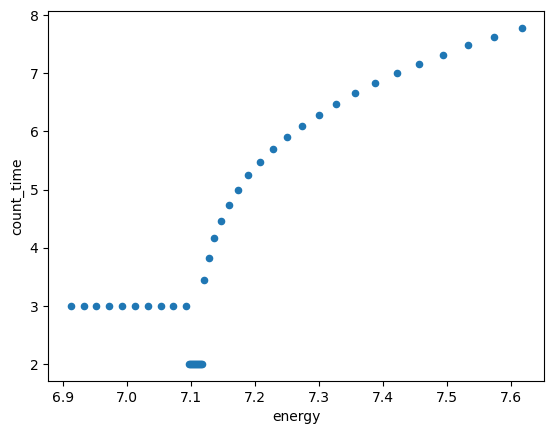

In [5]:
e_arr, t_arr = parse_segments(7.1125, DEFAULT_XAFS_SCAN_SEGMENTS)
df = pd.DataFrame(dict(energy=e_arr, count_time=t_arr))
df.plot.scatter("energy", "count_time")

## real-time computation of absorption coefficient
The absorption coefficient is computed from the ratio of two scaler channels.  We could compute that either in Python or EPICS.  Here, we choose an EPICS *userCalc* because its setup is more familiar to people experienced with EPICS.  The `instrument` package already provides support for 10 userCalcs.  We'll pick userCalc2 (since userCalc1 is already used by the simulated temperature controller).

The computation will update when it gets new values for either scaler channel.  In our `xafs()` scan below, we'll connect (separately, so we don't get all the other data provided by the userCalc support) with the calculated value (_log(I00/I0)_) as an additional _detector_.

In [6]:
def prep_absorption_calc(absorption):
    """
    Use a userCalc to compute ln(I00/I0) for real-time plots in collection.

    PARAMETERS

    absorption
        obj: instance of apstools.synApps.SwaitRecord()
    """
    absorption.reset()
    s = scaler1.channels
    yield from bps.mv(
        absorption.channels.A.input_pv, s.chan02.s.pvname,  # I0
        absorption.channels.B.input_pv, s.chan06.s.pvname,  # I00
        absorption.calculation, "ln(B/A)",  # ln(I00/I0)
        absorption.scanning_rate, "I/O Intr",
    )

## `xafs()` plan

With all the pieces defined, it is time to write a plan to measure the XAFS.  The caller must provide the absorption edge energy (in keV).  A list of segments is optional (will default to `DEFAULT_XAFS_SCAN_SEGMENTS` as defined above) so only the absorption edge energy is required.  Once the inputs are checked for correctness, the absorption calculation is setup in an EPICS userCalc ([SwaitRecord](https://apstools.readthedocs.io/en/latest/source/synApps/_swait.html#synapps-swait-record)).  Finally, the 1-D step scan is run by calling [bp.list_scan()](https://blueskyproject.io/bluesky/generated/bluesky.plans.list_scan.html#bluesky.plans.list_scan) with lists of energy and count time values for each step.

In [7]:
def xafs(edge_keV, segments=None, detectors=None):
    """
    Scan an edge: (keV

    EXAMPLE::

        RE(xafs(7.1125))  # scan iron K edge
    """
    if detectors is None:
        detectors = [scaler1]
    if segments is None:
        segments = DEFAULT_XAFS_SCAN_SEGMENTS
    if len(segments) == 0:
        return  # nothing to do

    # use userCalc2 to calculate absorption
    absorption = calcs.calc2
    yield from prep_absorption_calc(absorption)

    # override: just get the one signal
    absorption = EpicsSignalRO(
        calcs.calc2.calculated_value.pvname,
        name="absorption",
        kind="hinted"
    )
    detectors.append(absorption)

    scaler1.select_channels(("I0", "I00"))

    energy_list, count_time_list = parse_segments(edge_keV, segments)

    comment = (
        f"xafs of {len(segments)} segments (combined) near {edge_keV} keV"
        f": {len(energy_list)} points total"
    )
    logger.info(comment)
    yield from bp.list_scan(
        detectors,
        dcm.energy, energy_list,
        scaler1.preset_time, count_time_list,
        md=dict(
            purpose=comment,
            plan_name="xafs"
        )
    )

If the IOC was just started, the motor positions may not allow the monochromator code to operate.  Let's check it and move the motors only if necessary.

In [8]:

if (
    dcm.wavelength.position == 0
    and dcm.theta.position == 0
    and dcm.y1.get() == 0
    and dcm.z2.get() == 0
):
    from ophyd import EpicsMotor

    print(f"{dcm.name} is not initialized.  Moving motors to start position.")
    # The DCM controls do not allow operation of the underlying motors directly.
    # Let's move them anyway, just from this code.
    ioc = iconfig.get("GP_IOC_PREFIX")
    m_th = EpicsMotor(f"{ioc}m45", name="m_th")
    m_y1 = EpicsMotor(f"{ioc}m46", name="m_y1")
    m_z2 = EpicsMotor(f"{ioc}m47", name="m_z2")
    m_th.wait_for_connection()
    m_y1.wait_for_connection()
    m_z2.wait_for_connection()
    
    # we can't use Magicks so use RE to move them together
    # These settings are ~3.7 keV, where th & z2 are comparable
    # which means it takes roughly the same time to reach this position.
    RE(bps.mv(m_th, 32.3, m_y1, -20.7, m_z2, 32.7))

print(f"Initial {dcm.energy.position=:.4f} keV")

Initial dcm.energy.position=7.4563 keV


## XAFS scan with bluesky

I Thu-18:20:05 - xafs of 4 segments (combined) near 7.1125 keV: 44 points total




Transient Scan ID: 965     Time: 2023-04-13 18:20:05
Persistent Unique Scan ID: '13d5ecf4-55dd-41d8-9a96-4231230e6200'
New stream: 'label_start_motor'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+
|   seq_num |       time | dcm_energy |         I0 |        I00 | absorption |
+-----------+------------+------------+------------+------------+------------+
|         1 | 18:20:07.9 |     6.9125 |          4 |          2 |   -0.69315 |
|         2 | 18:20:09.6 |     6.9325 |          3 |          3 |    0.00000 |
|         3 | 18:20:11.4 |     6.9525 |          4 |          3 |   -0.28768 |
|         4 | 18:20:13.1 |     6.9725 |          3 |          3 |    0.00000 |
|         5 | 18:20:14.9 |     6.9925 |          3 |          4 |    0.28768 |
|         6 | 18:20:16.7 |     7.0125 |          4 |          2 |   -0.69315 |
|         7 | 18:20:18.4 |     7.0325 |          2 |          3 |    0.40547 |
|         8 | 18:20:20.1 |     7.05

('13d5ecf4-55dd-41d8-9a96-4231230e6200',)

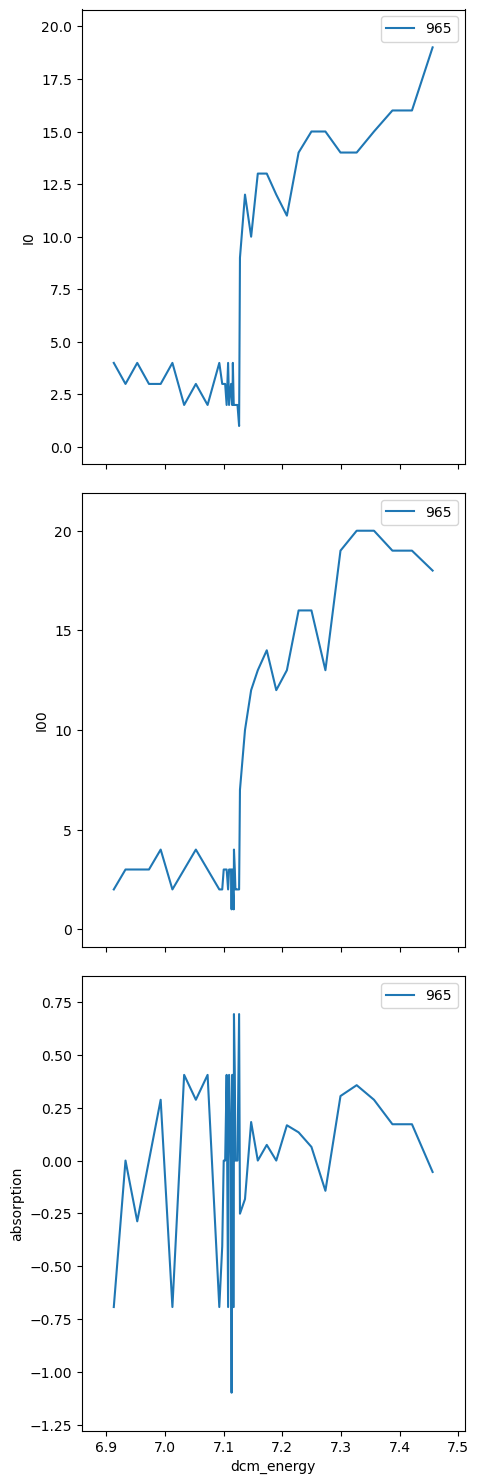

In [10]:
# move near the starting point
RE(bps.mv(dcm.energy, 7))

my_segments = (  # faster than above, just for the demo
    # X could be keV, eV, k, or kwt (k-weighted count time)
    # axis, start, end, step, count_time
    ("keV", -.2, -.015, .02, .6),
    ("eV", -15, 10, 2.5, .5),
    ("k", .5, 2, .2, 0.4),
    ("kwt", 2, 10, .5, .5),
)

# start the scan
RE(xafs(7.1125, segments=my_segments))

## Challenges

1. Scan XAFS with 3 segments (below-edge, near-edge, above-edge regions).
2. Explain why we can't we scan in negative _k_-space.
3. Modify the software to allow the user to control the _k_ weighting terms: `factor` and `exponent`.
4. Modify the `xafs()` plan to accept user metadata.  (hint: provide for a `md` keyword argument that will be a dictionary.  See `bp.list_scan??` for an example.)

## References

- https://docs.xrayabsorption.org/tutorials/XAFS_Fundamentals.pdf
- https://docs.xrayabsorption.org/Workshops/IIT2013/Newville_Theory.pdf
- https://en.wikipedia.org/wiki/X-ray_absorption_fine_structure
- web tool: https://nbeaver.github.io/k-space-calculator/
- https://github.com/nbeaver/k-space-calculator